In [ ]:
!pip install mlxtend --quiet

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import dlib
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import os
import imageio
from mlxtend.image import extract_face_landmarks

In [28]:
# data = pd.read_csv("age_gender.csv",usecols=["age", "ethnicity", "gender"])
# ethnic_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Hispanic"}
# data["ethnicity"] = [ethnic_dict[x] for x in data["ethnicity"]]
# data["gender"] =["Male" if x ==0 else "Female" for x in data["gender"]]
# data["path"] = pd.Series(["images\img"+str(x)+".jpg" for x in np.arange(0,len(data))])
# data.to_csv("cleaned_original.csv")

In [29]:
data = pd.read_csv("cleaned_original.csv")

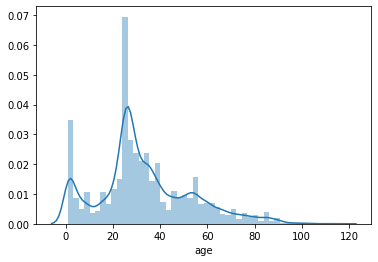

In [30]:
import matplotlib.pyplot as plt

sns.distplot(data['age'])
plt.show()

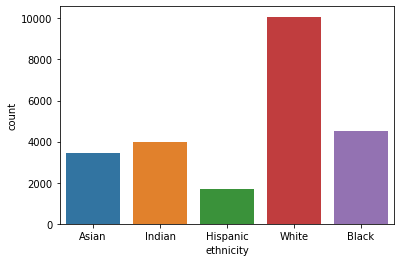

In [31]:
sns.countplot(data['ethnicity'])
plt.show()

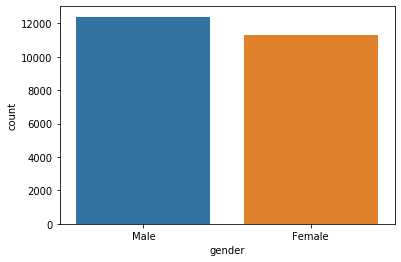

In [32]:
sns.countplot(data['gender'])
plt.show()

In [45]:
def get_photo(img_path):
    return imageio.imread(os.path.join(img_path))
get_photo("images\img10126.jpg")

Array([[[ 69,  69,  69],
        [ 63,  63,  63],
        [ 65,  65,  65],
        ...,
        [ 58,  58,  58],
        [ 52,  52,  52],
        [ 51,  51,  51]],

       [[ 69,  69,  69],
        [ 66,  66,  66],
        [ 68,  68,  68],
        ...,
        [ 49,  49,  49],
        [ 39,  39,  39],
        [ 36,  36,  36]],

       [[ 68,  68,  68],
        [ 69,  69,  69],
        [ 71,  71,  71],
        ...,
        [ 39,  39,  39],
        [ 28,  28,  28],
        [ 24,  24,  24]],

       ...,

       [[ 44,  44,  44],
        [ 45,  45,  45],
        [ 46,  46,  46],
        ...,
        [184, 184, 184],
        [207, 207, 207],
        [222, 222, 222]],

       [[ 43,  43,  43],
        [ 44,  44,  44],
        [ 45,  45,  45],
        ...,
        [175, 175, 175],
        [191, 191, 191],
        [210, 210, 210]],

       [[ 43,  43,  43],
        [ 44,  44,  44],
        [ 45,  45,  45],
        ...,
        [170, 170, 170],
        [182, 182, 182],
        [204, 204, 204]]

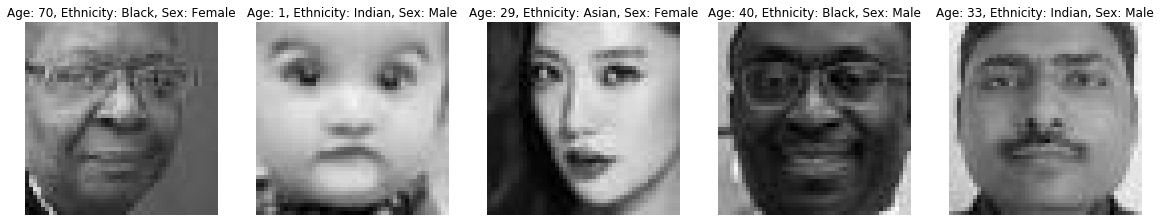

In [47]:
def n_random_faces(n):
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    folder = r"images"
    for i in range(n):
        row = data.sample().reset_index()
        axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(row["age"][0], row['ethnicity'][0], row["gender"][0]))
        axes[i].imshow(get_photo(row['path'][0]))
        axes[i].axis('off')
    return
n_random_faces(5)

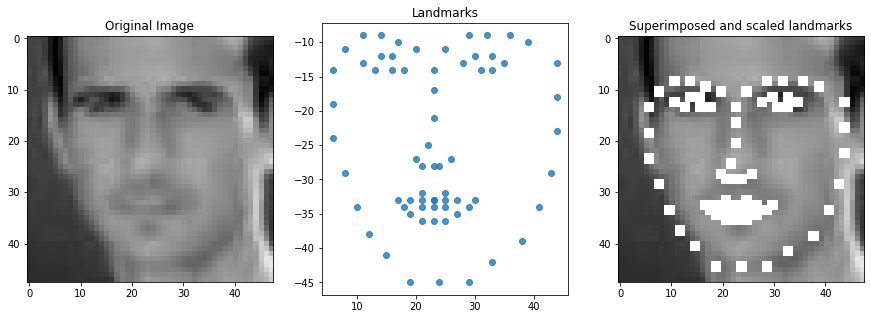

array([[ 6, 14],
       [ 6, 19],
       [ 6, 24],
       [ 8, 29],
       [10, 34],
       [12, 38],
       [15, 41],
       [19, 45],
       [24, 45],
       [29, 45],
       [33, 42],
       [38, 39],
       [41, 34],
       [43, 29],
       [44, 23],
       [44, 18],
       [44, 13],
       [ 8, 11],
       [11,  9],
       [14,  9],
       [17, 10],
       [20, 11],
       [25, 11],
       [29,  9],
       [32,  9],
       [36,  9],
       [39, 10],
       [23, 14],
       [23, 17],
       [23, 21],
       [22, 25],
       [20, 27],
       [21, 28],
       [23, 28],
       [24, 28],
       [26, 27],
       [11, 13],
       [14, 12],
       [16, 12],
       [18, 14],
       [16, 14],
       [13, 14],
       [28, 13],
       [30, 12],
       [33, 12],
       [35, 13],
       [33, 14],
       [31, 14],
       [17, 33],
       [19, 33],
       [21, 32],
       [23, 33],
       [25, 32],
       [27, 33],
       [30, 33],
       [27, 35],
       [25, 36],
       [23, 36],
       [21, 36

In [55]:
def find_landmarks(img_path):
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    img = get_photo(img_path)
    landmarks = extract_face_landmarks(img)
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[1].scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)
    ax[1].set_title("Landmarks")
    img2 = img.copy()
    for p in landmarks:
        img2[p[1]-1:p[1]+1, p[0]-1:p[0]+1, :] = (255, 255, 255)
    ax[2].imshow(img2)
    ax[2].set_title("Superimposed and Acaled Landmarks")
    plt.show()
    return landmarks

find_landmarks("images\img10126.jpg")

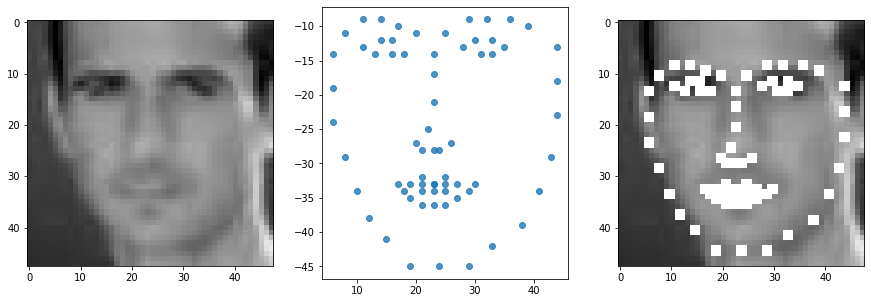

In [50]:
img = get_photo("images\img10126.jpg")
landmarks = extract_face_landmarks(img)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)
ax = fig.add_subplot(1, 3, 3)
img2 = img.copy()
for p in landmarks:
    img2[p[1]-1:p[1]+1, p[0]-1:p[0]+1, :] = (255, 255, 255)

ax.imshow(img2)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(landmarks[:,0], -landmarks[:,1], 'ro', markersize=8, alpha = 0.5)
for i in range(landmarks.shape[0]):
    plt.text(landmarks[i,0]+1, -landmarks[i,1], str(i), size=14)


left_eye_center = np.mean(landmarks[left_eye], axis=0)
right_eye_center = np.mean(landmarks[right_eye], axis=0)
print('Coordinates of the Left Eye: ', left_eye_center)
print('Coordinates of the Right Eye: ', right_eye_center)
plt.plot([left_eye_center[0]], [-left_eye_center[1]], 
            marker='+', color='blue', markersize=10, mew=4)

plt.plot([right_eye_center[0]], [-right_eye_center[1]], 
            marker='+', color='blue', markersize=10, mew=4)

plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
matplotlib.image.imsave('img2.jpg', data['pixels'][10300])

In [ ]:
img2 = cv2.imread('img2.jpg')
plt.imshow(img2)
image_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap = "gray")

In [ ]:
img = imageio.imread('img2.jpg')
landmarks = extract_face_landmarks(img)
landmarks

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)
ax = fig.add_subplot(1, 3, 3)
img2 = img.copy()

for p in landmarks:
    img2[p[1]-3:p[1]+3, p[0]-3:p[0]+3, :] = (255, 255, 255)

ax.imshow(img2)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(landmarks[:,0], -landmarks[:,1], 'ro', markersize=8, alpha = 0.5)
for i in range(landmarks.shape[0]):
    plt.text(landmarks[i,0]+1, -landmarks[i,1], str(i), size=14)


left_eye_center = np.mean(landmarks[left_eye], axis=0)
right_eye_center = np.mean(landmarks[right_eye], axis=0)
print('Coordinates of the Left Eye: ', left_eye_center)
print('Coordinates of the Right Eye: ', right_eye_center)
plt.plot([left_eye_center[0]], [-left_eye_center[1]], 
            marker='+', color='blue', markersize=10, mew=4)

plt.plot([right_eye_center[0]], [-right_eye_center[1]], 
            marker='+', color='blue', markersize=10, mew=4)

plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
img2 = imageio.imread('img2.jpg')
landmarks = extract_face_landmarks(img2)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img2)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)
ax = fig.add_subplot(1, 3, 3)
img0 = img2.copy()
for p in landmarks:
    img0[p[1]-1:p[1]+1, p[0]-1:p[0]+1, :] = (255, 255, 255)

ax.imshow(img0)
plt.show()